In [125]:
from sklearn.neural_network import MLPRegressor
import numpy as np
import pandas as pd
import data_extraction
import ARIMA
from datetime import datetime
import matplotlib.pyplot as plt

In [126]:
def ANN_train(X_train, y_train, hidden_layers, alpha=1e-5, random_state=1):
    '''
    INPUT:
    timeseries: TYPE: DataFrame. Contains column named 'residual'
    q: TYPE: Integer. Decides how many historical values to consider
    hidden_layers: TYPE: Tuple of integers. The number on the i'th position decides number of nodes in hidden layer i

    OUTPUT:
    Returns trained model: TYPE: MLPRegressor
    '''
    model = MLPRegressor(solver="lbfgs", 
                         alpha=alpha, 
                         hidden_layer_sizes=hidden_layers, 
                         random_state=random_state, 
                         max_iter=20000,
                         tol=1e-4) #default tolerance
    model.fit(X_train, y_train)
    return model

In [127]:
past_vals = 400
nRowsRead = None
grid_number = 1

df = pd.DataFrame(index = data_extraction.get_timeseries("train", nRowsRead, 'load', grid_number).append(data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number)).index)
df["residuals"] = data_extraction.get_timeseries("train", nRowsRead, 'load', grid_number).append(data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number))



In [128]:
df

,residuals
2017-12-01 00:00:00,449.53200
2017-12-01 01:00:00,439.03600
2017-12-01 02:00:00,442.23700
2017-12-01 03:00:00,447.83600
2017-12-01 04:00:00,463.99500
...,...
2020-05-30 20:00:00,224.54790
2020-05-30 21:00:00,223.84220
2020-05-30 22:00:00,217.77730
2020-05-30 23:00:00,208.35270


In [129]:
def data_ANN_train(past_vals, df):
    # input values
    # past_vals is the number of past values of the residuals that the ANN will use
    residuals = df["residuals"]
    load_series_train = data_extraction.get_timeseries("train", nRowsRead, 'load', grid_number)
    load_series_test = data_extraction.get_timeseries("train", nRowsRead, 'load', grid_number)
    
    X = []
    y = []
    
    for i in range(len(residuals.values) - len(load_series_test) - past_vals):
        X_el = residuals[i:i+past_vals]
        
        t = datetime.strptime(residuals.index[i+past_vals], "%Y-%m-%d %H:%M:%S")
        
        X_el_additional = []
        X_el_additional.append(t.hour)
        X_el_additional.append(t.month)

        # add the load of the predicted value
        X_el_additional.append(load_series_train[i+past_vals])
        
        X_el_additional = pd.Series(X_el_additional, name = X_el.name)

        df = pd.DataFrame(X_el.append(X_el_additional, ignore_index = True))
        nd = df.values

        nd_new = np.ndarray(shape=len(df.values))


        for j in range(len(nd)):
            nd_new[j] = nd[j,0]

        X.append(nd_new)
        y.append(residuals.iloc[i+past_vals])
    
    return X, y


In [130]:
X, y = data_ANN_train(past_vals, df)



In [131]:
model = ANN_train(X, y, (4))

In [104]:
def data_ANN_test(past_vals, df):
    residuals = df["residuals"]
    df["pred_residuals"] = ""
    load_series_test = data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number)
    #print(len(residuals[len(load_series_test)-past_vals:len(load_series_test)]))
    
    X = []
    
    for i in range(len(load_series_test)):
        if i%24 == 0:
            X_el = residuals[len(load_series_test)+i-past_vals:len(load_series_test)+i]
            #print(len(X_el))
        
        #if i == 0:
        #    print(X_el)
        
        t = datetime.strptime(load_series_test.index[i], "%Y-%m-%d %H:%M:%S")

        X_el_additional = []
        X_el_additional.append(t.hour)
        X_el_additional.append(t.month)

        # add the load of the predicted value
        X_el_additional.append(load_series_test[i])
        
        X_el_additional = pd.Series(X_el_additional, name = X_el.name)

        df = pd.DataFrame(X_el.append(X_el_additional, ignore_index = True))
        nd = df.values

        nd_new = np.ndarray(shape=len(df.values))


        for j in range(len(nd)):
            nd_new[j] = nd[j,0]

        
        if i == 0:
            print(len(nd_new))
        
        X.append(nd_new)
        X_el = X_el[1:]
        
        #if i == 0:
        #    print(len(X_el))
    
    
    return X
    

In [105]:
X_test = data_ANN_test(past_vals, df)

43


In [106]:
print(len(X_test[0]))
print(len(data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number)))

43
4310


In [113]:
def ANN_pred(model, X_test):
    X = X_test.copy()
    y_test = []
    for i in range(len(X)):
        X_el = X[i]
        X_losses = X_el[:-3]
        
        for j in range(i%24):
            y_test_el = np.ndarray(shape=1)
            v = y_test[- (i%24 - j)]
            y_test_el[0] = v
            X_losses = np.append(X_losses, y_test_el)

        X[i] = np.append(X_losses, X_el[-3:])
        
        val = model.predict([X[i]])

        y_test.append(val[0])
    return y_test



In [114]:
len(X_test)

4310

In [115]:
y_pred = ANN_pred(model, X_test)


In [116]:
len(y_pred)

4310

In [119]:
loss_series_test = data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number)

In [120]:
len(loss_series_test)

4310

In [121]:
df1 = pd.DataFrame(index=loss_series_test.index)

In [122]:
df1["Pred"] = y_pred
df1["Actual"] = loss_series_test.values
df1["diff"] = df["Actual"]-df["Pred"]

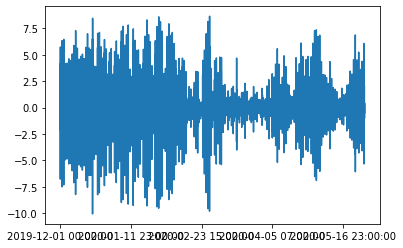

In [123]:
df1["diff"].plot()